# Determining Stellar Properties in the Presence of Correlated Noise
## Using covariance matrices to cope with systematic errors
Ian Czekala, Harvard CfA
iancze@gmail.com

# Some observations

1. The individual pixels of any spectrum are correlated (if the CCD properly samples the LSF...)
2. Bad lines (class I, II, III) still contain information about the stellar properties
3. class III lines may contain *the most* information about stellar properties, since these are where the gradient changes fastest
4. rather than masking, these need to be weighted properly

$\chi^2$ is generally defined as 

$$\chi^2 = A^T C^{-1} A$$ 

where $A = [Y - f(X)]$, and $Y$ is a vector of data points. The model points are $f(X)$. $C$ is the covariance matrix describing the relation between the data points, which is a square matrix of size $N \times N$, where $N$ is the length of $Y$. When $C$ has off-diagonal terms the matrix is non-trivial and the noise is correlated. If $C$ is large and non-trivial, then finding the inverse $C^{-1}$ can be very computationally difficult. In this module we will explore covariance matrices and possible uses of sparse matrices to speed up the calculation of $\chi^2$.

Being more proper about things, the multidimensional Gaussian is defined as

$$p(\textbf{y}) = \frac{1}{\sqrt{(2 \pi)^N \det(C)}} \exp\left ( -\frac{1}{2} \textbf{r}^T C^{-1} \textbf{r} \right ) $$

Taking the log, we have

$$ \ln(p) = \ln \left ( \frac{1}{\sqrt{(2 \pi)^N \det(C)}} \right ) -\frac{1}{2} \textbf{r}^T C^{-1} \textbf{r}  $$

$$ \ln(p) = -\frac{1}{2} \textbf{r}^T C^{-1} \textbf{r} - \ln \sqrt{(2 \pi)^N \det(C) } $$

$$ \ln(p) = -\frac{1}{2} \textbf{r}^T C^{-1} \textbf{r} - \ln (2 \pi)^N - \ln \det(C)^{1/2} $$

$$ \ln(p) = -\frac{1}{2} \textbf{r}^T C^{-1} \textbf{r} - \frac{1}{2} \ln \det C  - \frac{N}{2} \ln 2 \pi $$

In [1]:
#Import all of the relevant python modules
import numpy as np
import scipy.sparse as sp #Sparse array module
from scipy.sparse.linalg import inv as sinv
from scipy.sparse.linalg import spsolve
from numpy.linalg import inv,det

import matplotlib
import matplotlib.pyplot as plt
#Adjust figure size
#matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)

## Fake dataset

We create a fake data set as a straight line (stellar continuum) with a Gaussian absorption line profile with added Gaussian noise. 

The line function is

$$f_l(x | b, m) = b + m x$$

In [2]:
def line(x, b, m):
    return b + m * x

The Gaussian function is

$$f_G(x | a, \mu, \sigma) = \frac{a}{\sqrt{2 \pi} \sigma} \exp \left ( \frac{- (x - \mu)^2}{2 \sigma^2} \right ) $$

In [3]:
def gauss(x, amp=15, mu=0, sigma=1):
    return amp/np.sqrt(2 * np.pi * sigma**2) * np.exp(-0.5 * x**2/ sigma**2)

In [4]:
xs = np.linspace(-20, 20, num=50)
npoints = len(xs)
#Create a continuum with a gaussian absorption line superimposed. Add Gaussian noise.
ys = line(xs, 10, 0.05) - gauss(xs, amp=15, mu=0, sigma=1) + np.random.normal(size=npoints)

#Assume our model can only produce straight lines (ie, stellar continuum) in this region of the spectrum
model_ys = line(xs, 10, 0.05)

residuals = ys - model_ys

Plot the data set and the residuals using the best model we can muster

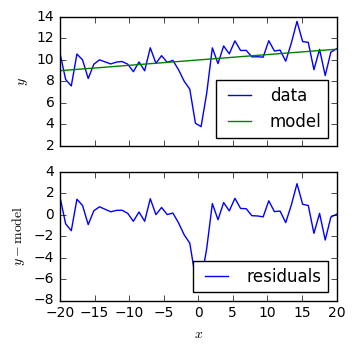

In [5]:
fig, ax = plt.subplots(nrows=2,sharex=True, figsize=(3.5,3.5))
ax[0].plot(xs, ys, label="data")
ax[0].plot(xs, model_ys, label="model")
ax[0].set_ylabel(r"$y$")
ax[0].legend(loc="lower right")

ax[1].plot(xs, residuals, label="residuals")
ax[1].legend(loc="lower right")
ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel(r"$y - {\rm model}$")
fig.subplots_adjust(left=0.17, bottom=0.15, right=0.96, top=0.96)
fig.savefig("../plots/fake_line.png")
fig.savefig("../plots/fake_line.eps")
plt.show()


The "true" parameters of this data set are for the straight line, $b = 10$, $m = 0.2$ and for the Gaussian $a = 15$, $\mu = 0$, $\sigma = 1$. We see that there is a systematic error present in the residuals where our straight line model could not reproduce the Gaussian absorption line. If we could represent this systematic residual as correlated noise--via the covariance matrix--then we should be able to get a reasonable $\chi^2$ for our fit, while also identifying the location of the Gaussian.

# Generating a covariance matrix

## Gaussian function

Covariance matrices can be described by the following notation. The mean function is

$$m(x) = E[f(x)]$$

and the covariance function is

$$k(x, x^\prime) = E[(f(x) - m(x))(f(x^\prime) - m(x^\prime))]$$

Then, we can compute the covariance function for a Gaussian, like in our residuals, as 

$$k(x, x^\prime | a, \mu, \sigma) = \frac{a^2}{2 \pi \sigma} \exp \left ( - \frac{[(x - \mu)^2 + (x^\prime - \mu)^2]}{2 \sigma^2}\right ) $$

Then, to create the covariance matrix $C$, we evaluate $k(x, x^\prime)$ for each $C_{ij}$. To speed things up, we truncated the Gaussian to $0$ beyond $\pm 3 \sigma$. The following is a (slow) way to initialize the covariance matrix as a sparse array.

In [6]:
def C(amp, mu, sigma, var=1):
    '''Return the covariance matrix as a sparse array'''
    S = sp.dok_matrix((npoints, npoints), dtype=np.float64)
    for i in range(npoints):
        for j in range(npoints):
            x0 = xs[i]
            x1 = xs[j]
            if np.abs(x0) < 4*sigma and np.abs(x1) < 4*sigma:
                if i == j:
                    S[i,j] = amp**2/(2 * np.pi * sigma**2) * np.exp(-((x0 - mu)**2 + (x1 - mu)**2)/(2 * sigma**2)) + var
                else:
                    S[i,j] = amp**2/(2 * np.pi * sigma**2) * np.exp(-((x0 - mu)**2 + (x1 - mu)**2)/(2 * sigma**2))
            elif i == j:
                S[i,j] = var
    return S

In [7]:
#Use S as a variable to denote the sparse covariance matrix
S = C(15, 0, 1)

In order to visualize what this (50 x 50) matrix looks like, we can plot the sparsity (ie, which elements are non-sparse)

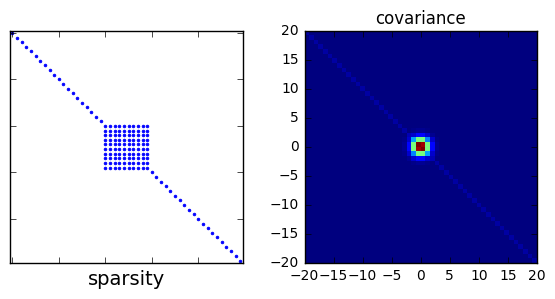

In [8]:
#Dual plot including sparsity diagram
fig, ax = plt.subplots(ncols=2, figsize=(6,3))
ax[0].spy(S, markersize=4, marker=".")
ax[0].set_xlabel("sparsity", size=14)
for tick in ax[0].yaxis.get_major_ticks():
    tick.label1On = False
    tick.label2On = False
for tick in ax[0].xaxis.get_major_ticks():
    tick.label1On = False
    tick.label2On = False
ax[1].imshow(S.todense(),interpolation="none",extent=[-20,20,-20,20], origin="upper")
ax[1].set_title("covariance")
fig.subplots_adjust(left=0.05, right=0.95)
plt.savefig("../plots/matrix_region.png")
plt.savefig("../plots/matrix_region.eps")
plt.show()

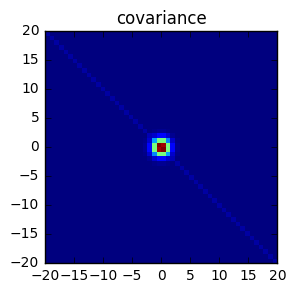

In [9]:
#single plot of just covariance
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.imshow(S.todense(),interpolation="none",extent=[-20,20,-20,20], origin="upper")
ax.set_title("covariance")

plt.savefig("../plots/matrix_region_covariance.png")
plt.show()

We see from these two plots that most of the array is $0$ except for the diagonals and a central region about $x = 0$, which we initialized from the $k(x, x^\prime)$. Thus, the noise in the central region of the data set is correlated while it is uncorrelated elsewhere.

## Drawing samples from the covariance matrix

To further show that this covariance matrix describes the correlation of data points in the central region, we can try drawing random samples from the noise distribution. In the un-correlated case, this would be equivalent to generating each $y_i$ point individually as a draw from a Gaussian  random noise distribution. However, because we now have correlated points, we need to draw from a multi-dimensional Gaussian and use the covariance matrix we just created. We generate 20 fake noise sets and then overplot the actual residuals on top.

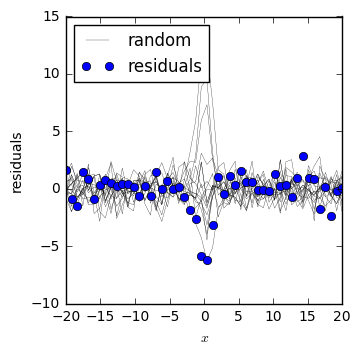

In [10]:
S_dense = S.todense() #Convert the sparse array to a dense array. Necessary for multivariate_normal.

fig = plt.figure(figsize=(3.5,3.5))
ax = fig.add_subplot(111)

for i in range(15):
    #Generate a fake noise set centered on mu = 0 and with covariance matrix we just determined
    y_reals = np.random.multivariate_normal(np.zeros((npoints,)), S_dense)
    ax.plot(xs, y_reals, "k",lw=0.2)
    
ax.plot(xs, y_reals, "k",lw=0.2, label="random")
#overplot our actual residuals
ax.plot(xs, residuals, "bo", label="residuals")
ax.legend(loc="upper left")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"residuals")
fig.subplots_adjust(bottom=0.15,left=0.18, right=0.97, top=0.97)
plt.savefig("../plots/random_draw.png")
plt.savefig("../plots/random_draw.eps")
plt.show()

And we see that the two are consistent.

# Chi squared using a covariance matrix with off-diagonal terms

Now that we have identified an appropriate covariance matrix, we will use it to finally compute $\chi^2$

In [11]:
def calcA(b, m):
    '''residual'''
    return ys - line(xs, b, m)

In [12]:
A = calcA(10, 0.2)
S = C(amp=15, mu=0, sigma=1)

In order to compute $\chi^2$ according to our equation, we need to find the inverse of $C$. 

In [13]:
Sinv = sinv(S.tocsc())
result = Sinv.dot(A)
chi2 = A.T.dot(result)
print("Chi squared = {:.1f}".format(chi2))

Chi squared = 207.1


As far as we want to trust it, we see that the $\chi^2$ is on the same order as the number of data points ($N = 50$). However, as $C$ grows larger with $N$, this operation as we have phrased it can become prohibitively expensive.

In [14]:
timeit sinv(S.tocsc()) #tocsc converts the form of the sparse matrix

100 loops, best of 3: 12 ms per loop


Instead, we use the sparse linear equation solver to bypass the inversion of $C$ to achieve the same result with more efficient computation

In [15]:
chi2 = A.T.dot(spsolve(S,A))
print("Chi squared = {:.1f}".format(chi2))

Chi squared = 207.1


/usr/local/AstroPhysics/Python_Anaconda/anaconda2/envs/python34/lib/python3.4/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:101: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


As we go to larger $N$, this operation is still efficient

In [16]:
timeit spsolve(S,A)

/usr/local/AstroPhysics/Python_Anaconda/anaconda2/envs/python34/lib/python3.4/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:101: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


The slowest run took 5.71 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 312 µs per loop


# Using the covariance formalism to find the posterior on the line parameters $b$, $m$ and the Gaussian parameters $a$, $\mu$, and $\sigma$.

Now that we have created a $\chi^2$ function, we will use `emcee` to sample the posterior. This may be sort of a contrived example, because we are assuming the presence of a *single* Gaussian. We set hard priors for sensible parameter values ($\sigma > 0$, $a \le 0$ since any sign information in the amplitude is erased by squaring it, and centering the Gaussian such that $\mu$ must fall within the range of $x$ values in our data set. 

We also set a flat prior in the logarithm of $a$, since it is a scale parameter. This prior encodes our ignorance about the possible *magnitude* of the Gaussian. We could also set something different.

In [17]:
def chi_func(b, m, aG, muG, sigmaG):
    A = calcA(b, m)
    S = C(amp=aG, mu=muG, sigma=sigmaG)
    chi2 = A.T.dot(spsolve(S,A))
    return chi2

Here are some samples of the lnprob function, just to get an idea of what's going on

In [21]:
def lnprob(param):
    return -0.5 * chi_func(param[0],param[1],param[2],param[3],param[4])

In [22]:
timeit lnprob(np.array([10, 0.2, 15, 0, 1]))

/usr/local/AstroPhysics/Python_Anaconda/anaconda2/envs/python34/lib/python3.4/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:101: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


100 loops, best of 3: 4.17 ms per loop


*That's really fast, about the same as the non-cholesky factored Julia solution.* I think we are in business for the Python approach

In [23]:
print(lnprob(np.array([10, 0.2, 15, 0, 1]))) #"true" parameters
print(lnprob(np.array([10, 0.2, 20, 0, 1]))) 

-103.552902211
-103.303607279


/usr/local/AstroPhysics/Python_Anaconda/anaconda2/envs/python34/lib/python3.4/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:101: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


Now what happens if we use the same covariance function on a region where there is no line (we erase the line by adding the Gaussian back in)

In [24]:
ys += gauss(xs, amp=15, mu=0, sigma=1)

In [25]:
print(lnprob(np.array([10, 0.2, 0, 0, 1]))) #"true" parameters
print(lnprob(np.array([10, 0.2, 15, 0, 1]))) 
print(lnprob(np.array([10, 0.2, 20, 0, 1]))) 

-103.217154836
-102.982083749
-102.980770542


/usr/local/AstroPhysics/Python_Anaconda/anaconda2/envs/python34/lib/python3.4/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:101: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


Interestingly, the model with a covariance provides a better lnprob for there being no line vs. being a line. However, the line strength (dependent on some other stellar parameters) and $a$ are correlated, such that the best lnprob is achieved with no line and $a = 0$. That sounds like a desireable behavior to me.

Because we wish to eventually sample this function, we will have to revisit our covariance function, `C`. As written, it uses python for loops, which will be slow as we move towards large $N$. This alternate version only calculates the non-zero entries to save time.

In [26]:
def gauss_func(x0i, x1i, x0v=None, x1v=None, amp=None, mu=None, sigma=None):
    x0 = x0v[x0i]
    x1 = x1v[x1i]
    return amp**2/(2 * np.pi * sigma**2) * np.exp(-((x0 - mu)**2 + (x1 - mu)**2)/(2 * sigma**2))

In [27]:
def Cfast(xs, amp, mu, sigma, var=1):
    '''Create a sparse covariance matrix using identity and block_diagonal'''
    #In the region of the Gaussian, the matrix will be dense, so just create it as `fromfunction`
    #Above this region, the matrix will be simply Identity.
    
    #The matrix is also symmetric about the diagonal
    
    #Given mu, and the extent of sigma, estimate the data points that are above, in Gaussian, and below
    n_above = np.sum(xs < (mu - 4 * sigma))
    n_below = np.sum(xs > (mu + 4 * sigma))
    ind_in = (xs >= (mu - 4 * sigma)) & (xs <= (mu + 4 * sigma)) #indices to grab the x values 
    len_in = np.sum(ind_in)
    #print(n_above, n_below, len_in)
    #that will be needed to evaluate the Gaussian
    
    if len_in == 0:
        return sp.identity(len(xs), format="csc")
    else:    
        #Create Gaussian, add the sparse diagonal to it
        x_gauss = xs[ind_in]
        gauss_mat = np.fromfunction(gauss_func, (len_in,len_in), x0v=x_gauss, x1v=x_gauss, amp=amp, mu=mu, sigma=sigma, dtype=np.int)
        gauss_mat = gauss_mat + np.identity(len_in)
        
        #plt.imshow(gauss_mat)
        if n_above == 0 and n_below == 0:
            return sp.csc_matrix(gauss_mat)
        elif n_above == 0:
            return sp.block_diag((gauss_mat, sp.identity(n_below)), format="csc")
        elif n_below == 0:
            return sp.block_diag((sp.identity(n_above), gauss_mat), format="csc")
        else:
            return sp.block_diag((sp.identity(n_above), gauss_mat, sp.identity(n_below)), format="csc")

How to initialize a csc_matrix using the list approach

In [28]:
data = np.array([3, 3, 3])
ij = np.array([[0, 1, 2],[0, 1 , 2]])
mymat = sp.csc_matrix((data, ij))

In [31]:
def Cregion(xs, amp, mu, sigma, var=1):
    '''Create a sparse covariance matrix using identity and block_diagonal'''
    #In the region of the Gaussian, the matrix will be dense, so just create it as `fromfunction`
    #and then later turn it into a sparse matrix with size xs x xs
        
    #Given mu, and the extent of sigma, estimate the data points that are above, in Gaussian, and below
    n_above = np.sum(xs < (mu - 4 * sigma))
    n_below = np.sum(xs > (mu + 4 * sigma))
    
    #Create dense matrix and indexes, then convert to lists so that you can pack things in as:
    
    #csc_matrix((data, ij), [shape=(M, N)])
    #where data and ij satisfy the relationship a[ij[0, k], ij[1, k]] = data[k]
    
    len_x = len(xs)
    ind_in = (xs >= (mu - 4 * sigma)) & (xs <= (mu + 4 * sigma)) #indices to grab the x values 
    len_in = np.sum(ind_in)
    #print(n_above, n_below, len_in)
    #that will be needed to evaluate the Gaussian
    
     
    #Create Gaussian matrix fromfunction
    x_gauss = xs[ind_in]
    gauss_mat = np.fromfunction(gauss_func, (len_in,len_in), x0v=x_gauss, x1v=x_gauss, 
                                amp=amp, mu=mu, sigma=sigma, dtype=np.int).flatten()
    
    #Create an index array that matches the Gaussian
    ij = np.indices((len_in, len_in)) + n_above
    ij.shape = (2, -1)
    
    return sp.csc_matrix((gauss_mat, ij), shape=(len_x,len_x))
    

Create many bad regions

In [32]:
S = Cregion(xs, 10, -20, 1) + Cregion(xs, 10, 0, 1) + Cregion(xs, 10, 20, 1) + sp.eye(len(xs))

In [33]:
def lnprob(p):
    b, m, a, mu, sigma = p
    if sigma <= 0 or a < 0 or mu < xs[0] or mu > xs[-1]:
        return -np.inf
    else:
        return - chi_fast(*p) - 0.1 * a

In [34]:
timeit np.log(np.linalg.det(S.todense()))

The slowest run took 77.31 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 107 µs per loop


In [35]:
timeit s, logdet = np.linalg.slogdet(S.todense())

The slowest run took 6.78 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 102 µs per loop


In [36]:
timeit Cregion(xs, 10, 0, 1)

1000 loops, best of 3: 270 µs per loop


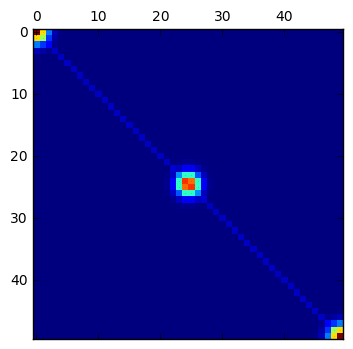

In [42]:
plt.imshow(S.todense(),origin="upper",interpolation="none")
plt.show()

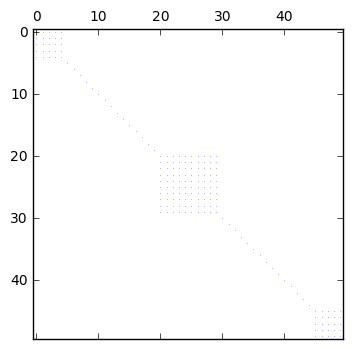

In [44]:
plt.spy(S, markersize=0.1, marker=".")
plt.show()

In [45]:
def lnprob_fast(b,m):
    A = calcA(b, m)
    S = Cregion(xs, 10, -20, 1) + Cregion(xs, 10, 0, 1) + Cregion(xs, 10, 20, 1) + sp.eye(len(xs))
    s, logdet = np.linalg.slogdet(S.todense())
    if s <= 0:
        return -np.inf
    lnp =  -0.5 * (A.T.dot(spsolve(S,A)) + logdet)
    return lnp   
    

In [46]:
lnprob_fast(10, 0.2)

-81.161734478570267

It turns out that sparse matrix generation works really well.

In [41]:
def chi_fast(b, m, aG, muG, sigmaG):
    A = calcA(b, m)
    S = Cfast(xs, amp=aG, mu=muG, sigma=sigmaG)
    chi2 = A.T.dot(spsolve(S,A))
    return chi2

## Alternative ways to build sparse matrices

1. Initialize/store the "bad regions" as actual sparse matrices that have a shape 2300,2300, that way they can be easily added to build up large matrices, as long as the regions themselves do not overlap. (What if they do overlap?) For example, in this case we can use the from_function() numpy array creation method, instantiate as a sparse matrix, and then add the whole thing, rather than using the complicated block_diagonal methods.
2. 

We initialized the sampler as follows

In [47]:
import emcee

# Initialize the sampler with the chosen specs.
nwalkers = 30
burn_in = 600
ndim = 5
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

#Declare starting indexes
m = np.random.uniform(low=7, high=12, size=(nwalkers,))
b = np.random.uniform(low=0.1, high=0.3, size=(nwalkers,))
a = np.random.uniform(low=0, high=20, size=(nwalkers,))
mu = np.random.uniform(low=-1, high=1, size=(nwalkers,))
sigma = np.random.uniform(low=0.5, high=3, size=(nwalkers,))

p0 = np.array([m, b, a, mu, sigma]).T

Run the sampler for the burn in period, then make a plot of the results using the awesome `triangle_plot`

Burned in chain


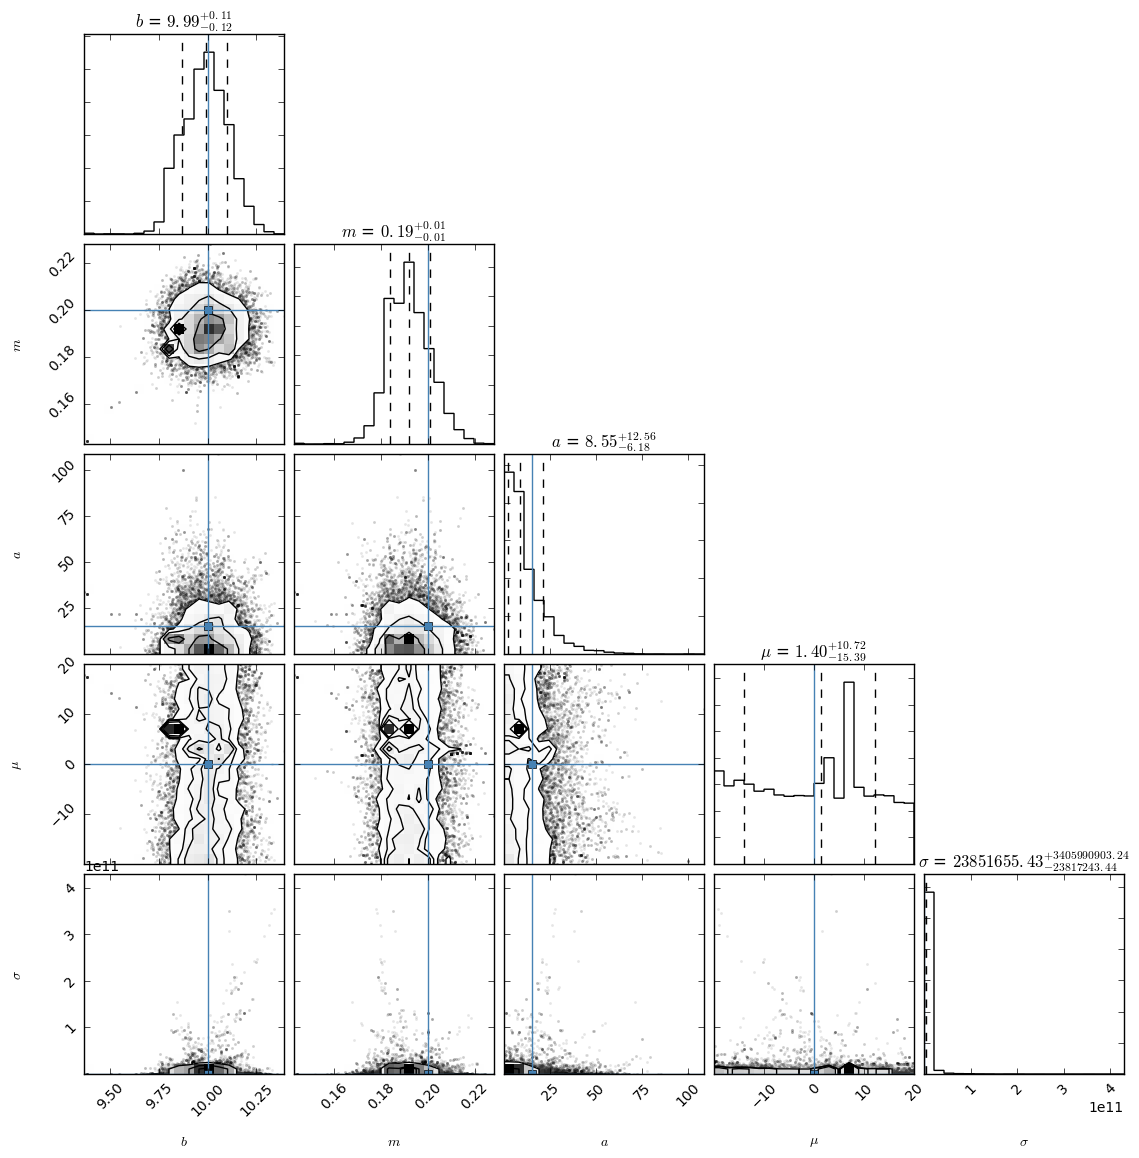

In [54]:
pos, prob, state = sampler.run_mcmc(p0, burn_in)

print("Burned in chain")
# Reset the chain to remove the burn-in samples.
sampler.reset()

#Now the production run
sampler.run_mcmc(pos, 1000, rstate0=state)

#plot the results
import corner as triangle

samples = sampler.flatchain
figure = triangle.corner(samples, labels=[r"$b$", r"$m$", r"$a$", r"$\mu$", r"$\sigma$"], truths=[10., 0.2, 15, 0, 1],
                         quantiles=[0.16, 0.5, 0.84],
                         show_titles=True, title_args={"fontsize": 12})
figure.savefig("../plots/triangle.png")
plt.show()

We see that we recover the parameters that we specified (marked by the blue crosses). 

How well does this approach work if there is NO line there? Does it set the amplitude to 0?

In [55]:
xs = np.linspace(-20, 20, num=50)
npoints = len(xs)
#Create a continuum with a gaussian absorption line superimposed. Add Gaussian noise.
ys = line(xs, 10, 0.2) + np.random.normal(size=npoints)

#Assume our model can only produce straight lines (ie, stellar continuum) in this region of the spectrum
model_ys = line(xs, 10, 0.2)

residuals = ys - model_ys

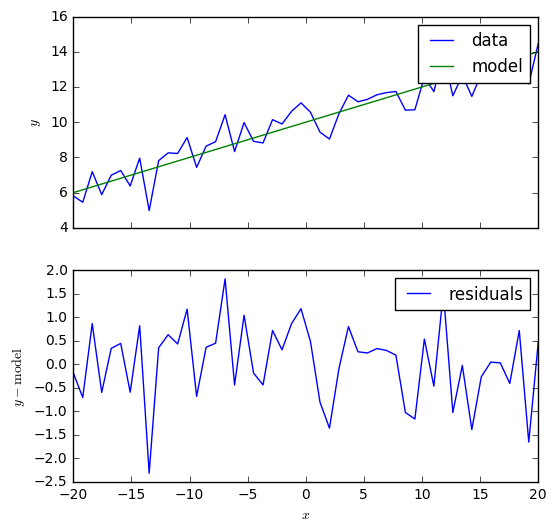

In [56]:
fig, ax = plt.subplots(nrows=2,sharex=True, figsize=(6,6))
ax[0].plot(xs, ys, label="data")
ax[0].plot(xs, model_ys, label="model")
ax[0].set_ylabel(r"$y$")
ax[0].legend()

ax[1].plot(xs, residuals, label="residuals")
ax[1].legend()
ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel(r"$y - {\rm model}$")
plt.show()

In [57]:
print(lnprob(np.array([9.94833141 , 0.18042412 , 5.04518683 , 4.91043678 , 4])))

-35.1152526991


In [58]:
print(lnprob(np.array([ 10.02358742 ,  0.21339782 , 77.09074508 , -4.05862656 ,  4.76014368])))

-42.9043266304


Burned in chain


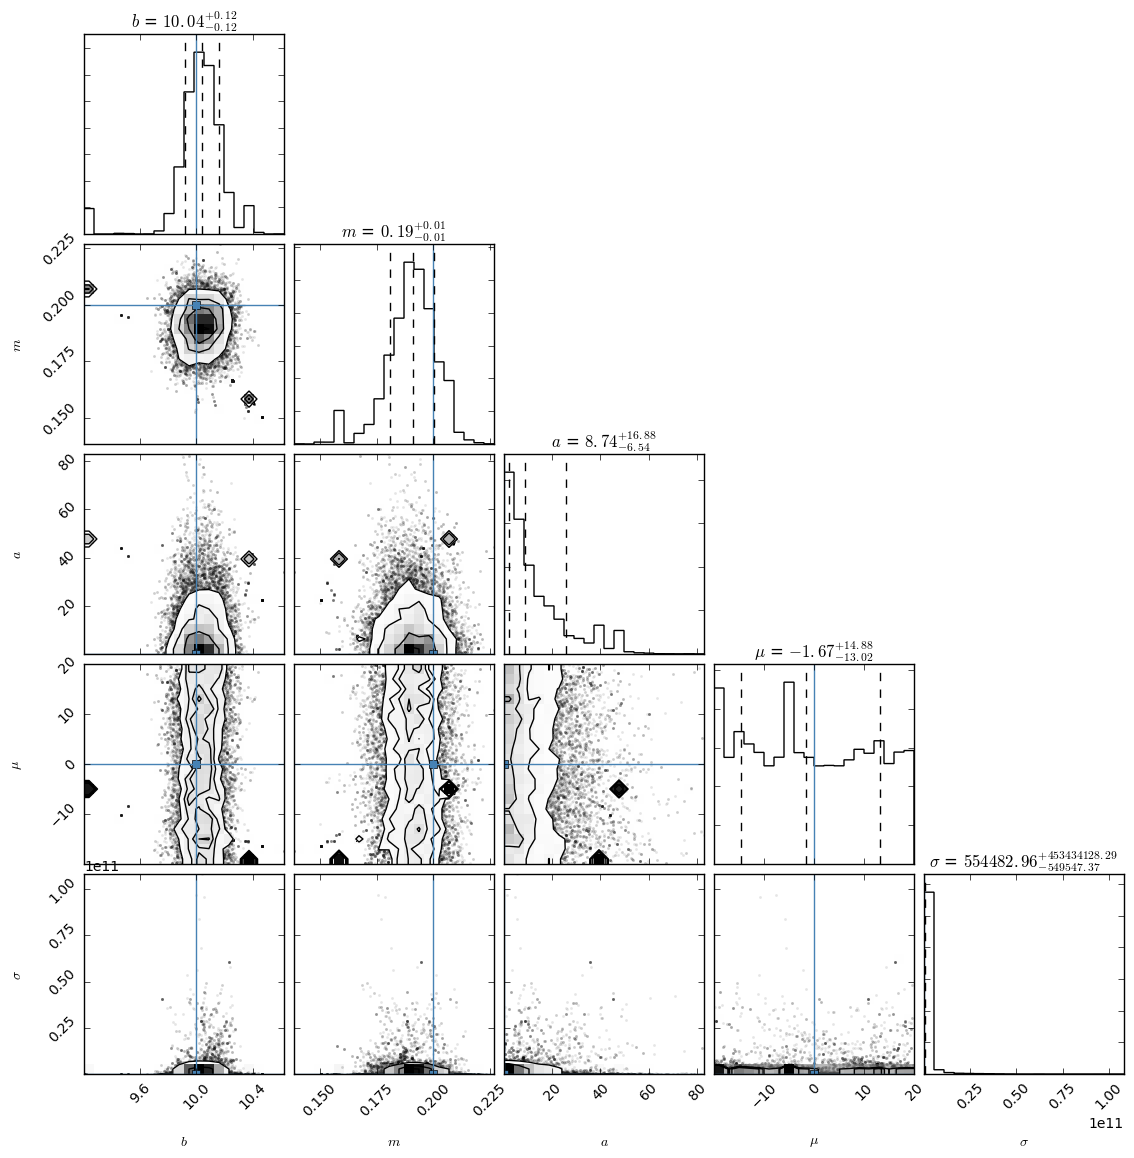

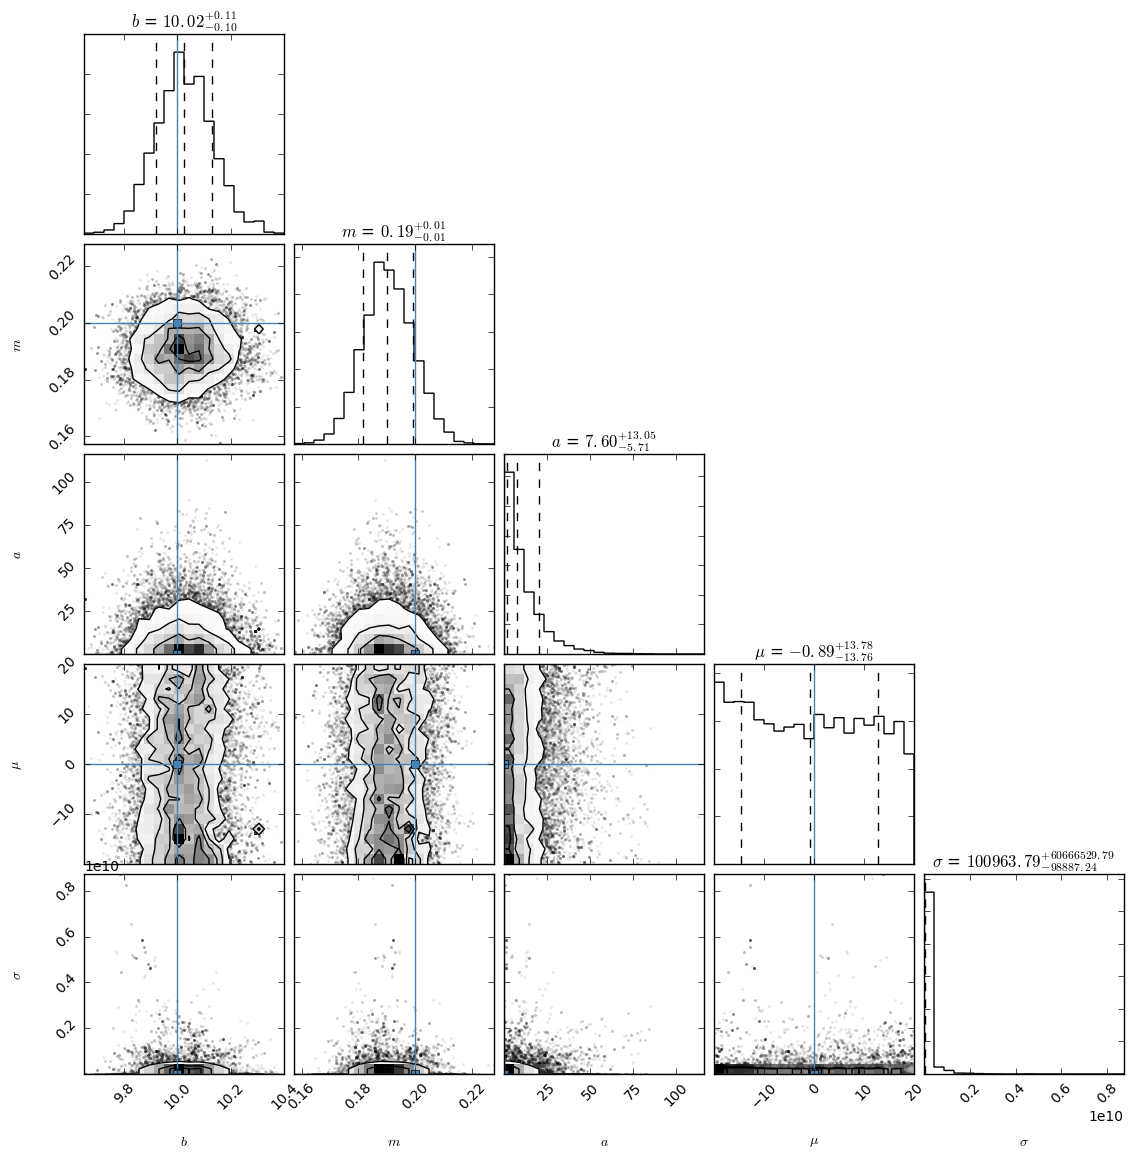

In [61]:
pos, prob, state = sampler.run_mcmc(p0, burn_in)

print("Burned in chain")
# Reset the chain to remove the burn-in samples.
sampler.reset()

#Now the production run
sampler.run_mcmc(pos, 1000, rstate0=state)

#plot the results
import corner as triangle

samples = sampler.flatchain
figure = triangle.corner(samples, labels=[r"$b$", r"$m$", r"$a$", r"$\mu$", r"$\sigma$"], truths=[10., 0.2, 0, 0, 1],
                         quantiles=[0.16, 0.5, 0.84],
                         show_titles=True, title_args={"fontsize": 12})
figure.savefig("../plots/triangle2.png")
plt.show()

Thankfully, we see that the solution is consistent with zero if there is indeed no line. This is good news. If we introduce a line and it's zero for a long time, then we can remove it.

#Expanding the approach to non-Gaussian shaped systematics

Now that we have this working relatively fast for the toy model case of a single Gaussian line, we can extend this to include many lines throughout the whole spectrum. At this point, you may be thinking that this was simply a lot of work just to accomplish the same thing that could have been done by *injecting a fake line* of Gaussian shape. However, this approach is much more flexible because we are not limited to lines of Gaussian shape. Say that we have a region of an M dwarf spectrum is bad, which that looks like the region at 0.65 $\mu$m from Mann et al 2013:

In [ ]:
from IPython.display import display
from IPython.display import Image
i = Image(filename='../paper/mann.png')
display(i)

Rather than use a Gaussian for $k(x, x^\prime)$, we can use a more general covariance function, such as the 'squared exponential' but with an added Gaussian taper

$$k(x, x^\prime | h, a, \mu, \sigma) = \exp \left ( \frac{-( x - x^\prime)^2 }{2 h^2} \right ) \frac{a^2}{2 \pi \sigma} \exp \left ( - \frac{[(x - \mu)^2 + (x^\prime - \mu)^2]}{2 \sigma^2}\right )$$

here $h$ is a "bandwidth" that controls the power of the oscillations. If $h$ is small, then there will be high-frequency structure. If $h$ is large, then only low-frequency structure will remain.

In [ ]:
def exp_func(x0i, x1i, x0v=None, x1v=None, h=None, amp=None, mu=None, sigma=None):
    x0 = x0v[x0i]
    x1 = x1v[x1i]
    return amp**2/(2 * np.pi * sigma**2) * np.exp(-((x0 - mu)**2 + (x1 - mu)**2)/(2 * sigma**2)) * np.exp(-0.5 * (x0 - x1)**2/h**2)

In [ ]:
def Cexp(xs, h, amp, mu, sigma, var=1):
    '''Create a sparse covariance matrix using identity and block_diagonal'''
    #In the region of the Gaussian, the matrix will be dense, so just create it as `fromfunction`
    #Above this region, the matrix will be simply Identity.
    
    #The matrix is also symmetric about the diagonal
    
    #Given mu, and the extent of sigma, estimate the data points that are above, in Gaussian, and below
    n_above = np.sum(xs < (mu - 4 * sigma))
    n_below = np.sum(xs > (mu + 4 * sigma))
    ind_in = (xs >= (mu - 4 * sigma)) & (xs <= (mu + 4 * sigma)) #indices to grab the x values 
    len_in = np.sum(ind_in)
    #print(n_above, n_below, len_in)
    
    if len_in == 0:
        return sp.identity(len(xs), format="csc")
    else:    
        #Create Gaussian, add the sparse diagonal to it
        x_gauss = xs[ind_in]
        gauss_mat = np.fromfunction(exp_func, (len_in,len_in), x0v=x_gauss, x1v=x_gauss, h=h,
                                    amp=amp, mu=mu, sigma=sigma, dtype=np.int)
        gauss_mat = gauss_mat + np.identity(len_in)
        
        #plt.imshow(gauss_mat)
        return sp.block_diag((sp.identity(n_above), gauss_mat, sp.identity(n_below)), format="csc")

Now we can fool around and tune parameters to give a messy looking M dwarf region

In [ ]:
S = Cexp(xs, 1.2, 50, 0, 3)
S_dense = S.todense() #Convert the sparse array to a dense array. Necessary for multivariate_normal.

fig = plt.figure(figsize=(3.5,3.5))
ax = fig.add_subplot(111)
for i in range(10):
    #Generate a fake noise set centered on mu = 0 and with covariance matrix we just determined
    y_reals = np.random.multivariate_normal(np.zeros((npoints,)), S_dense)
    ax.plot(xs, y_reals, "k",lw=0.2)
    
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"residuals")
ax.set_title("M dwarf residual")
fig.subplots_adjust(left=0.17, bottom=0.12, right=0.96)
fig.savefig('../plots/mdwarf.png')

This isn't as pretty as the example with a pure Gaussian line, but what's interesting is that now the spectral line residual can make several twists and turns between the region of $x \in \pm 10$, accounting for the correlated systematic of an incorrectly modeled molecular band-head. 

Looking at the covariance matrix, we see that it appears similar to the pure-Gaussian example. However now it is more elongated thanks to the small $h$ in the squared-exponential covariance function.

In [ ]:
fig = plt.figure(figsize=(3.5,3.5))
ax = fig.add_subplot(111)
ax.imshow(S_dense, origin="upper",interpolation="none")
fig.subplots_adjust(right=0.97,top=0.96)
fig.savefig("../plots/mdwarf_matrix.png")

I think this could be a very powerful approach for dealing with our bad spectral regions in a generic manner. In order to recover the original Gaussian behavior we just need to set $h$ to something larger than the $\sigma$ of the tapering Gaussian.

In [ ]:
S = Cexp(xs, 2, 15, 0, 1)
S_dense = S.todense() #Convert the sparse array to a dense array. Necessary for multivariate_normal.

for i in range(20):
    #Generate a fake noise set centered on mu = 0 and with covariance matrix we just determined
    y_reals = np.random.multivariate_normal(np.zeros((npoints,)), S_dense)
    plt.plot(xs, y_reals, "k",lw=0.2)
    
#overplot our actual residuals
plt.plot(xs, residuals, "bo", label="data residuals")
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"residuals")

#References

* [Triangle Plot](https://github.com/dfm/triangle.py)
* [Mann 2013](http://adsabs.harvard.edu/abs/2013ApJ...779..188M)